Optical chirality
=========================================

<span style="color: red;">**!!Attention!!**:</span> *linear.optical_chirality* is still beta functionality and is to be used with caution and on own risk. 


In this example, we reproduce the chirality of the optical near-field close to a plasmonic nanostructure of a configuration from *Schäferling et al.* [1].

First we load pyGDM, construct the geometry and setup the simulation.


[1]: Schäferling et al.: *Tailoring Enhanced Optical Chirality: Design Principles for Chiral Plasmonic Nanostructures* **PRX** 2, 031010 (2012) (https://doi.org/10.1103/PhysRevX.2.031010)

In [1]:
from pyGDM2 import structures
from pyGDM2 import materials
from pyGDM2 import fields

from pyGDM2 import core
from pyGDM2 import tools
from pyGDM2 import linear
from pyGDM2 import visu

import numpy as np
import matplotlib.pyplot as plt



#==============================================================================
# pyGDM setup - geometry
#==============================================================================
## --- Setup geometry
mesh = 'cube'
step = 20

## rebuild structure from Giessen paper 
## (Schäferling et al. PRX 2, 031010 (2012))
full_geo = structures.rect_wire(step, L=int(400/step), W=int(400/step), H=2)
full_geo = full_geo[np.logical_not(np.logical_and(np.logical_and(
                full_geo.T[0]>40, 
                full_geo.T[0]<=120),
                full_geo.T[1]<=-40) )]
full_geo = full_geo[np.logical_not(np.logical_and(np.logical_and(
                full_geo.T[0]<=-40, 
                full_geo.T[1]>-120),
                full_geo.T[1]<=-40) )]

full_geo = full_geo[np.logical_not(np.logical_and(np.logical_and(
                full_geo.T[0]<=-40, 
                full_geo.T[0]>-120),
                full_geo.T[1]>40) )]
full_geo = full_geo[np.logical_not(np.logical_and(np.logical_and(
                full_geo.T[0]>40, 
                full_geo.T[1]<=120),
                full_geo.T[1]>40) )]


#==============================================================================
# pyGDM setup - simulation
#==============================================================================
material = materials.gold()
n1, n2 = 1.0, 1.0   # in vacuum

struct = structures.struct(step, full_geo, material, n1,n2, 
                                   structures.get_normalization(mesh))


## --- Setup incident field: LCP and RCP plane wave
field_generator = fields.planewave
wavelengths = [2500]
kwargs = dict(polarization_state = [(1,1,np.pi/2.,0), (1,1,-np.pi/2.,0)], kSign=1)
efield = fields.efield(field_generator, wavelengths=wavelengths, kwargs=kwargs)

sim = core.simulation(struct, efield)

visu.structure(sim)
print ('N_dipoles sim =', len(sim.struct.geometry))

/home/hans/.local/lib/python3.7/site-packages/pyGDM2-1.1rc1-py3.7-linux-x86_64.egg/pyGDM2/structures.py:145: UserWarning: Minimum structure Z-value lies below substrate level! Shifting structure bottom to Z=step/2.
  warnings.warn("Minimum structure Z-value lies below substrate level!" +
/home/hans/.local/lib/python3.7/site-packages/pyGDM2-1.1rc1-py3.7-linux-x86_64.egg/pyGDM2/visu.py:48: UserWarning: 3D data. Falling back to XY projection...
  warnings.warn("3D data. Falling back to XY projection...")


<Figure size 640x480 with 1 Axes>

N_dipoles sim = 544


running the simulation
--------------------------------

Now we run the simulation, calculate the optical chirality above and below the structure (and the RCP near-field intensity for comparison as well). Then we plot the results.

timing for wl=2500.00nm - setup: 998.8 ms, inv.: 541.4 ms, repropa.: 25.2ms (2 field configs), tot: 1566.4 ms


/home/hans/.local/lib/python3.7/site-packages/pyGDM2-1.1rc1-py3.7-linux-x86_64.egg/pyGDM2/linear.py:796: UserWarning: Chirality is a beta-functionality still under testing. Please use with caution.
  warnings.warn("Chirality is a beta-functionality still under testing. " +
/home/hans/.local/lib/python3.7/site-packages/pyGDM2-1.1rc1-py3.7-linux-x86_64.egg/pyGDM2/linear.py:810: ComplexWarning: Casting complex values to real discards the imaginary part
  ]).astype(np.float)
/home/hans/.local/lib/python3.7/site-packages/pyGDM2-1.1rc1-py3.7-linux-x86_64.egg/pyGDM2/visu.py:48: UserWarning: 3D data. Falling back to XY projection...
  warnings.warn("3D data. Falling back to XY projection...")


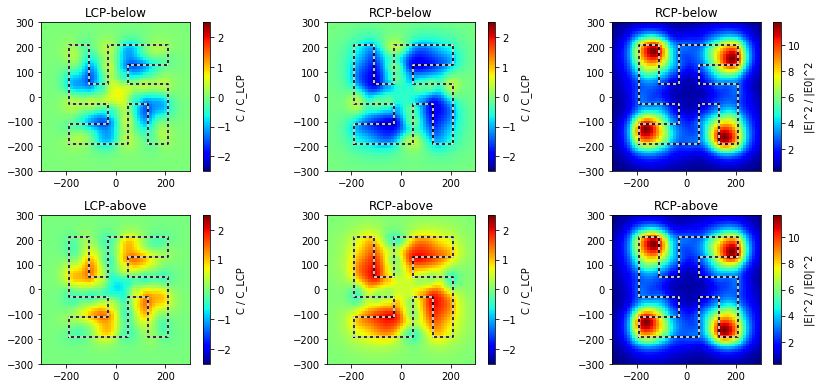

In [2]:
#==============================================================================
# run the simulation
#==============================================================================
core.scatter(sim, method='lu', matrix_setup='numba', verbose=True)


## indices of field configurations
fidx_LCP = 0      # LCP
fidx_RCP = 1      # RCP

## here the structure lies in positive z space 
## --> adapt Z values to match Schäferling, where structure is centered at z=0
Z0_below = -50
Z0_above = 90
r_probe_above = tools.generate_NF_map(-300,300,51, -300,300,51, Z0=Z0_above)
r_probe_below = tools.generate_NF_map(-300,300,51, -300,300,51, Z0=Z0_below)


## note: Schäferling seems to use always the scattered fields, so we do so here.
##       When comparing to experiment, it makes more sense to use the "full"
##       fields (E_scat + E_0), which can make quite a difference particularly
##       in non-resonant cases

## calculate NF intensity for RCP
Es_above, Et, Bs, Bt = linear.nearfield(sim, fidx_RCP, r_probe=r_probe_above)
Es_below, Et, Bs, Bt = linear.nearfield(sim, fidx_RCP, r_probe=r_probe_below)

## calculate NF chirality for LCP and RCP
C_LCP_below = linear.optical_chirality(sim, fidx_LCP, r_probe_below, which_field='s')
C_RCP_below = linear.optical_chirality(sim, fidx_RCP, r_probe_below, which_field='s')
C_LCP_above = linear.optical_chirality(sim, fidx_LCP, r_probe_above, which_field='s')
C_RCP_above = linear.optical_chirality(sim, fidx_RCP, r_probe_above, which_field='s')



# =============================================================================
# plot
# =============================================================================
def confplot(im, sim, C_label=True):
    visu.structure_contour(sim, color='k', lw=1.5, show=0)
    visu.structure_contour(sim, color='w', lw=1.5, dashes=[2,2], show=0)
    if C_label:
        im.set_clim(-2.5, 2.5)
        plt.colorbar(im, label='C / C_LCP')
    

plt.figure(figsize=(12, 5.5))


## --- below gammadion
plt.subplot(2,3,1, aspect='equal')
plt.title("LCP-below")
im = visu.scalarfield(C_LCP_below, cmap='jet', show=0)
confplot(im, sim)

plt.subplot(2,3,2, aspect='equal')
plt.title("RCP-below")
im = visu.scalarfield(C_RCP_below, cmap='jet', show=0)
confplot(im, sim)

plt.subplot(2,3,3, aspect='equal')
plt.title("RCP-below")
im = visu.vectorfield_color(Es_below, cmap='jet',show=0)
plt.colorbar(im, label="|E|^2 / |E0|^2")
confplot(im, sim, C_label=False)


## --- above gammadion
plt.subplot(2,3,4, aspect='equal')
plt.title("LCP-above")
im = visu.scalarfield(C_LCP_above, cmap='jet', show=0)
confplot(im, sim)

plt.subplot(2,3,5, aspect='equal')
plt.title("RCP-above")
im = visu.scalarfield(C_RCP_above, cmap='jet', show=0)
confplot(im, sim)

plt.subplot(2,3,6, aspect='equal')
plt.title("RCP-above")
im = visu.vectorfield_color(Es_above, cmap='jet',show=0)
plt.colorbar(im, label="|E|^2 / |E0|^2")
confplot(im, sim, C_label=False)


plt.tight_layout()
plt.show()

Comparison with [1]
--------------------------------

Comparison with the reference reveals a very good qualitative agreement:


![prx_giessen](chirality_example/prx_giessen.png)
**figure**: Chirality below and above a gold Gammadion illuminated by a circular polarized plane wave. From [1]